In [94]:
%load_ext autoreload
%autoreload 2


In [ ]:

import os
import torch
from skimage import io, measure
import numpy as np
import matplotlib.pyplot as plt

from tifffile import imread, imsave

import warnings
warnings.filterwarnings('ignore')

from tifffile import imread




if not torch.cuda.is_available():
    raise ValueError("GPU not found, code will run on CPU and can be extremely slow!")
else:
    device = torch.device("cuda:0")

import time
from glob import glob
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
import torch.optim as optim
import torch.utils.data as dt


import os
os.chdir('/mnt/c/Users/ankit/Desktop/Msc AIML/msc-project/GAP/gap')
from GAP_UNET_ResBlock_ffhq import UN
from BinomDataset_ffhq_inpaint_epsilon import BinomDataset
from DataFolderFFHQ import DataFolder
from inferencev3 import sample_image
from tasks import inpainting
from utils import preprocess, stats, stack_video

In [60]:
name = 'm40to30-256x256-ffhq-epsilon'
# name = 'm40to30-256x256-ffhq-run-2'
CHECKPOINT_PATH = '/mnt/c/Users/ankit/Desktop/Msc AIML/Data/checkpoints/models/'

model = UN(channels = 3, levels=10, depth=6,start_filts=32, 
           up_mode = 'upsample', merge_mode = 'concat').to(device)
model = UN.load_from_checkpoint(os.path.join(CHECKPOINT_PATH, name)+'.ckpt').to(device)

In [324]:
ffhq_path = '/mnt/c/Users/ankit/Desktop/Msc AIML/Data/ffhq/faces/'
minpsnr = -40
maxpsnr = 30
dataset = BinomDataset(ffhq_path, windowSize = 256, minPSNR = minpsnr, maxPSNR= maxpsnr, virtSize= 1)

In [270]:
channels = 3
differences = []
for i in range(100):
    img = dataset[0]
    target, input = img[:channels], img[channels  + 1 + 3:channels  + 1 + 3 + 3]
    print(target.sum() - input.sum())
    differences.append(target.sum() - input.sum())
print('done loop')

tensor(693504.)
tensor(1754.)
tensor(44.)
tensor(19.)
tensor(420.)
tensor(16949.)
tensor(35.)
tensor(54.)
tensor(69599.)
tensor(54220.)
tensor(7047936.)
tensor(69322.)
tensor(6766.)
tensor(7188352.)
tensor(2.)
tensor(140.)
tensor(15617.)
tensor(63.)
tensor(5417536.)
tensor(43118.)
tensor(43258.)
tensor(0.)
tensor(43879.)
tensor(11.)
tensor(26.)
tensor(47140.)
tensor(146.)
tensor(252766.)
tensor(2.)
tensor(29.)
tensor(1110.)
tensor(859.)
tensor(711.)
tensor(2173.)
tensor(4280.)
tensor(14.)
tensor(1593664.)
tensor(21338.)
tensor(267.)
tensor(8933.)
tensor(465096.)
tensor(4402240.)
tensor(49072.)
tensor(12740.)
tensor(175092.)
tensor(712.)
tensor(38.)
tensor(1836832.)
tensor(27.)
tensor(118.)
tensor(101053.)
tensor(609.)
tensor(461456.)
tensor(3529.)
tensor(1813.)
tensor(1486.)
tensor(84.)
tensor(5240512.)
tensor(1.)
tensor(1808656.)
tensor(455808.)
tensor(9.)
tensor(118.)
tensor(55016.)
tensor(10073.)
tensor(218.)
tensor(105.)
tensor(3.)
tensor(42269.)
tensor(24184.)
tensor(60.)
tensor(1

In [271]:
sorted(differences)[:20]

[tensor(0.),
 tensor(1.),
 tensor(1.),
 tensor(2.),
 tensor(2.),
 tensor(3.),
 tensor(4.),
 tensor(9.),
 tensor(11.),
 tensor(12.),
 tensor(14.),
 tensor(14.),
 tensor(19.),
 tensor(23.),
 tensor(26.),
 tensor(27.),
 tensor(29.),
 tensor(31.),
 tensor(33.),
 tensor(35.)]

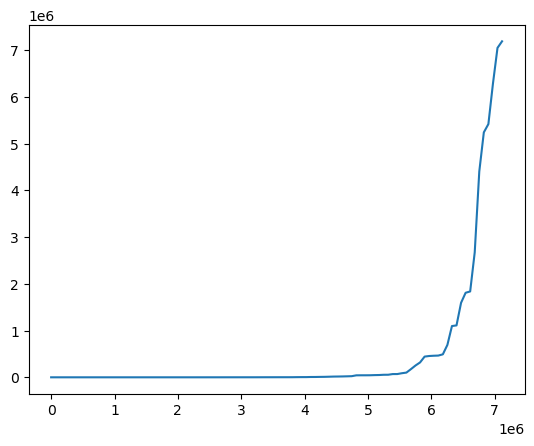

In [272]:
x = np.arange(0, max(differences), max(differences)/100)

plt.plot(x, sorted(differences))

In [322]:
count = 0
for i in differences:
    if i > 0 and i< 100000:
        count +=1
print(count)

77


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(True)

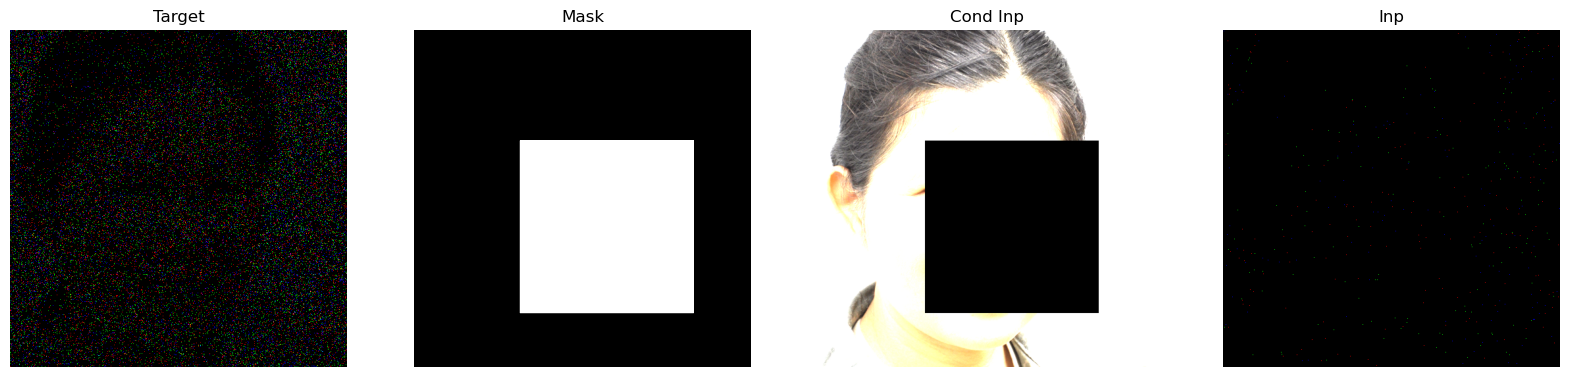

In [367]:
channels = 3
img = dataset[5000000000]
target, mask, cond, input = img[:channels].permute(1, 2, 0), img[channels:channels + 1].permute(1, 2, 0), img[channels + 1:channels  + 1 + 3].permute(1, 2, 0), img[channels  + 1 + 3:channels  + 1 + 3 + 3].permute(1, 2, 0)
plt.figure(figsize= (20, 20))
plt.subplot(1, 4, 1)
plt.imshow(target/target.mean())
plt.title('Target')
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow((mask)/mask.mean(), vmin = 0, vmax = 1, cmap= 'gray')
plt.title('Mask')
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow((cond)/cond.mean(), vmin = 0, vmax = 255)
plt.title('Cond Inp')
plt.axis('off')
plt.subplot(1, 4, 4)
plt.imshow((input)/input.mean(), vmin = 0, vmax = 255)
plt.title('Inp')
plt.axis('off')
# stats(target, input)
target.sum() > input.sum()

In [368]:
target.sum() - input.sum()

tensor(25815.)

(-0.5, 511.5, 511.5, -0.5)

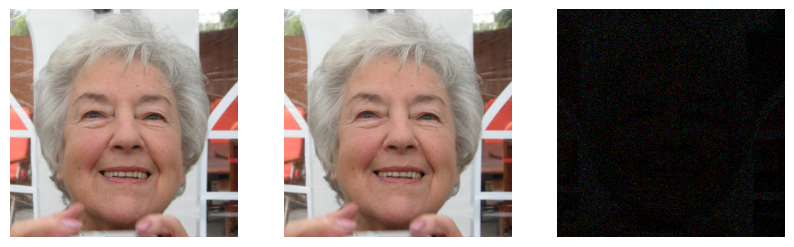

In [65]:
ffhq_path = '/mnt/c/Users/ankit/Desktop/Msc AIML/Data/ffhq/'
dataset = DataFolder(ffhq_path, minPSNR = -20, maxPSNR= 0, virtSize= 1)
dataTestGT, dataTestTarget, dataTest = dataset[0]

plt.figure(figsize= (10, 10))
plt.subplot(1, 3, 1)
plt.imshow(preprocess(dataTestGT))
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(preprocess(dataTestTarget))
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(preprocess(dataTest))
plt.axis('off')


torch.Size([3, 512, 512])


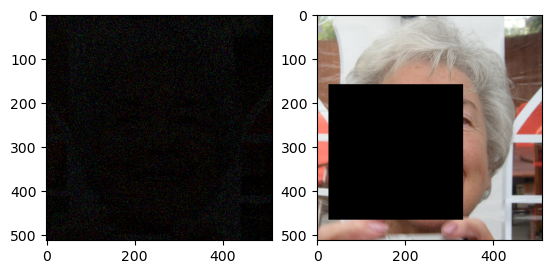

In [66]:
masks = inpainting(imgsize = 512, masksize = 256)
mask = masks.generate_mask().numpy()
test = dataTest 
testGT = dataTestGT/dataTestGT.mean()
cond_test = testGT * (1 - mask)
print(cond_test.shape)
plt.subplot(1, 2, 1)
plt.imshow(preprocess(test))
plt.subplot(1, 2, 2)
plt.imshow(preprocess(cond_test))

torch.Size([3, 512, 512])
torch.Size([1, 4, 512, 512])
torch.Size([3, 512, 512])
input shape : torch.Size([1, 7, 512, 512]), model input shape : torch.Size([1, 1, 7, 512, 512])

Shape : torch.Size([1, 3, 512, 512])

Min : 8.39304702822119e-05

Max : 0.05086866393685341

Sum : 3855.641357421875

Mean : 0.004902701359242201

tensor(255.) tensor(6.) tensor(53.2986) 255.0 150.0
inp shape : torch.Size([3, 512, 512])
out shape : torch.Size([1, 3, 512, 512])
gt shape : torch.Size([3, 512, 512])


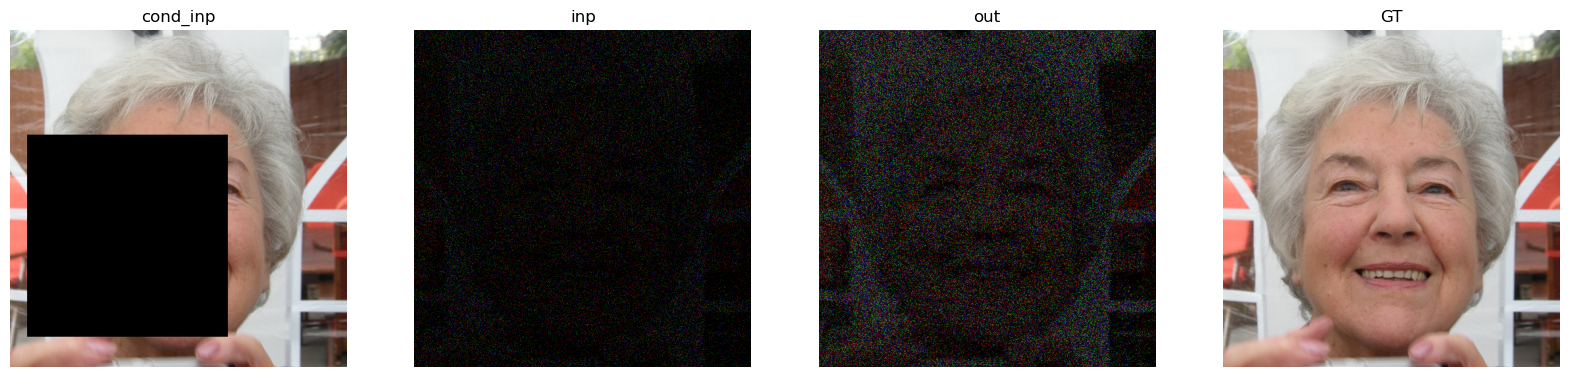

In [67]:
cond_input = torch.from_numpy(np.expand_dims(np.concatenate((mask, cond_test), axis = 0), axis = 0))

for inp, cinp, gt in zip(dataTest[None], cond_input[None], dataTestGT[None]): 
    print(inp.shape) 
    print(cinp.shape) 
    print(gt.shape) 

    inp = (inp).to(device) 
    cond_inpT = cinp.to(device)
    inpT = torch.cat([cond_inpT, inp[None]], dim = 1).to(device)
    print(f'input shape : {inpT.shape}, model input shape : {inpT[None].shape}')
    y = model(inpT).detach().cpu()
    out = np.exp(y)
    stats(out)
    # out = inp.sum() * out / out.sum() 
    
    print(gt.max(), gt.min(), gt.std(), np.percentile(gt,99.9), np.percentile(gt,50))

    # inp = inp/inp.mean()
    # out = out/out.mean()
    # gt = gt/gt.mean()
    # inp = inp/inp.max()
    # out = out/out.max()
    # gt = gt/gt.max()
    # cond_inp = cinp[1]/cinp[1].mean()

    
    print(f'inp shape : {inp.shape}')
    print(f'out shape : {out.shape}')
    print(f'gt shape : {gt.shape}')

    cond_vmax = np.percentile(preprocess(cond_test),99.9)
    plt.figure(figsize=(20,20))
    plt.subplot(1, 4, 1)
    plt.imshow(preprocess(cond_test) ,vmin = 0, vmax = cond_vmax)
    plt.title('cond_inp')
    plt.axis('off')

    vmax = np.percentile(preprocess(gt),99.9)
    plt.subplot(1, 4, 2)
    plt.imshow(preprocess(inp.detach().cpu()),vmin = 0, vmax = vmax)
    plt.title('inp')
    # plt.show()
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    plt.imshow(preprocess(out[0]),vmin = 0,vmax = vmax)
    plt.title('out')
    # plt.show()
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.imshow(preprocess(gt),vmin = 0,vmax = vmax)
    plt.title('GT')
    plt.axis('off')
    plt.show()
    


In [68]:
stats(inp), stats(out)


Shape : torch.Size([3, 512, 512])

Min : 0.0

Max : 5.0

Sum : 120027.0

Mean : 0.15262222290039062


Shape : torch.Size([1, 3, 512, 512])

Min : 8.39304702822119e-05

Max : 0.05086866393685341

Sum : 3855.641357421875

Mean : 0.004902701359242201



(None, None)

torch.Size([3, 512, 512])
torch.Size([1, 4, 512, 512])
torch.Size([3, 512, 512])
input shape : torch.Size([1, 7, 512, 512]), model input shape : torch.Size([1, 1, 7, 512, 512])
tensor(255.) tensor(6.) tensor(53.2986) 255.0 150.0
inp shape : torch.Size([3, 512, 512])
out shape : torch.Size([1, 3, 512, 512])
gt shape : torch.Size([3, 512, 512])


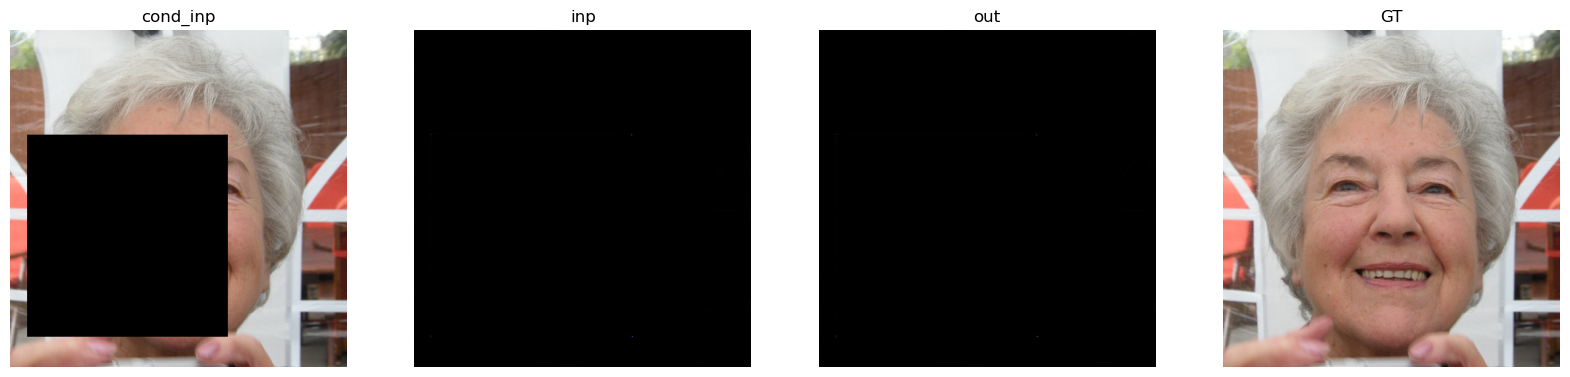

In [80]:
cond_input = torch.from_numpy(np.expand_dims(np.concatenate((mask, cond_test), axis = 0), axis = 0))

for inp, cinp, gt in zip(dataTest[None], cond_input[None], dataTestGT[None]): 
    print(inp.shape) 
    print(cinp.shape) 
    print(gt.shape) 

    inp = (out[0]).to(device) 
    cond_inpT = cinp.to(device)
    inpT = torch.cat([cond_inpT, inp[None]], dim = 1).to(device)
    print(f'input shape : {inpT.shape}, model input shape : {inpT[None].shape}')
    y = model(inpT).detach().cpu()
    out = np.exp(y)

    # out = inp.sum() * out / out.sum() 
    
    print(gt.max(), gt.min(), gt.std(), np.percentile(gt,99.9), np.percentile(gt,50))

    # inp = inp/inp.mean()
    # out = out/out.mean()
    # gt = gt/gt.mean()
    # inp = inp/inp.max()
    # out = out/out.max()
    # gt = gt/gt.max()
    # cond_inp = cinp[1]/cinp[1].mean()

    
    print(f'inp shape : {inp.shape}')
    print(f'out shape : {out.shape}')
    print(f'gt shape : {gt.shape}')

    cond_vmax = np.percentile(preprocess(cond_test),99.9)
    plt.figure(figsize=(20,20))
    plt.subplot(1, 4, 1)
    plt.imshow(preprocess(cond_test) ,vmin = 0, vmax = cond_vmax)
    plt.title('cond_inp')
    plt.axis('off')

    vmax = np.percentile(preprocess(gt),99.9)
    plt.subplot(1, 4, 2)
    plt.imshow(preprocess(inp.detach().cpu()),vmin = 0, vmax = vmax)
    plt.title('inp')
    # plt.show()
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    plt.imshow(preprocess(out[0]),vmin = 0,vmax = vmax)
    plt.title('out')
    # plt.show()
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.imshow(preprocess(gt),vmin = 0,vmax = vmax)
    plt.title('GT')
    plt.axis('off')
    plt.show()
    


In [81]:
stats(inp), stats(out)


Shape : torch.Size([3, 512, 512])

Min : 3.4454174056008924e-06

Max : 0.03397634997963905

Sum : 49.133846282958984

Mean : 6.24769163550809e-05


Shape : torch.Size([1, 3, 512, 512])

Min : 3.4454174056008924e-06

Max : 0.03397633507847786

Sum : 49.13385009765625

Mean : 6.247692363103852e-05



(None, None)

cond_input shape torch.Size([1, 4, 512, 512])
cond_img shape torch.Size([1, 4, 512, 512])
input_img shape torch.Size([1, 7, 512, 512])
input_img shape torch.float32
Iteration : 1
Iteration : 2
Iteration : 3
Iteration : 4
Iteration : 5
Iteration : 6
Iteration : 7
Iteration : 8
Iteration : 9
Iteration : 10
Iteration : 11
Iteration : 12
Iteration : 13
Iteration : 14
Iteration : 15
Iteration : 16
Iteration : 17
Iteration : 18
Iteration : 19
Iteration : 20
Iteration : 21
Iteration : 22
Iteration : 23
Iteration : 24
Iteration : 25
Iteration : 26
Iteration : 27
Iteration : 28
Iteration : 29
Iteration : 30
Iteration : 31
Iteration : 32
Iteration : 33
Iteration : 34
Iteration : 35
Iteration : 36
Iteration : 37
Iteration : 38
Iteration : 39
Iteration : 40
Iteration : 41
Iteration : 42
Iteration : 43
Iteration : 44
Iteration : 45
Iteration : 46
Iteration : 47
Iteration : 48
Iteration : 49
Iteration : 50
Iteration : 51
Iteration : 52
Iteration : 53
Iteration : 54
Iteration : 55
Iteration : 56
Iter

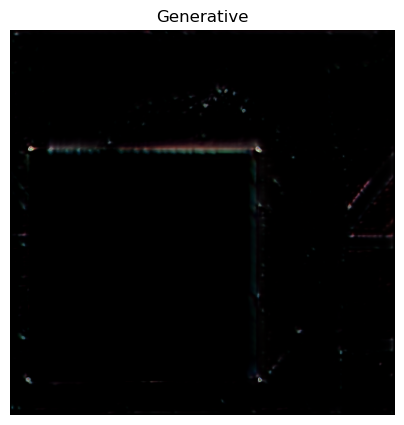

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


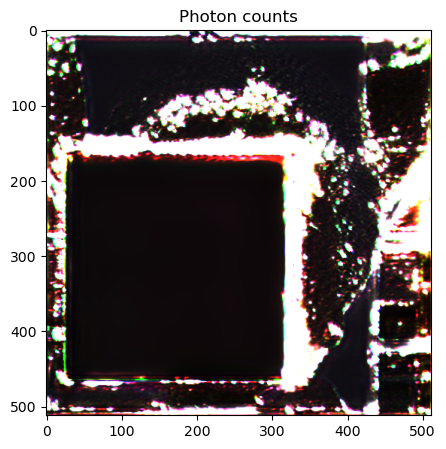

_______________________________________ 1016
time (s): 49.58184838294983 time per image (s) 49.58184838294983


In [84]:
import matplotlib.image as mpimg
import time
import numpy as np
from inference_ffhq import sample_image

# We are starting with an image containing zeros,
# i.e., sampling from scratch

# we just have 1 channel
channels = 3
# we can sample multiple images at the same time in a batch
batch_size = 1
# for best results this should correspond to training pach size
pixels_x = 512
pixels_y = 512

inp_img =  torch.zeros(batch_size ,channels, pixels_y, pixels_x)
# inp_img = test[None]
# masks2 = inpainting(imgsize = 512, masksize = 500)
# mask = masks2.generate_mask().numpy()
cond_input = torch.from_numpy(np.expand_dims(np.concatenate((mask, cond_test), axis = 0), axis = 0))
print(f'cond_input shape {cond_input.shape}')

cond_img = cond_input
print(f'cond_img shape {cond_img.shape}')

# cond_img = torch.zeros_like(cond_img)
input_img = torch.cat((cond_img, inp_img), 1).to(device)
print(f'input_img shape {input_img.shape}')
print(f'input_img shape {input_img.dtype}')


for i in range(1):
    

    startTime = time.time()
    
    # sampling the image(s)
    denoised, photons, stack, iterations = sample_image(input_img,
                                                        model, 
                                                        beta = 0.05,
                                                        save_every_n = 10,
                                                        max_psnr = 13,
                                                        max_its = 500000,
                                                        channels = 3,
                                                        use_poisson = False)

    
    # In case we do multiple images in a batch, we show all of them.
    for j in range(denoised.shape[0]):
#         print(iterations)
            # print(denoised.shape)
            # plt.figure(figsize = (5,5))
            # plt.imshow(denoised[j].transpose(1, 2, 0), cmap='inferno', vmin = 0,
            #            vmax = np.percentile(denoised[j],99.99))
            # plt.title('Generative')
            # plt.axis('off')
            # plt.show()
            
            # plt.figure(figsize = (5,5))
            # plt.imshow(photons[j,0], cmap='inferno', vmin = 0,
            #            vmax = np.percentile(photons[j],99.99))
            # plt.title('Photon counts')
            # plt.show()
            denoised/=denoised.mean()
            print(denoised.shape)
            plt.figure(figsize = (5,5))
            plt.imshow(denoised[0].transpose(1, 2, 0)/denoised[0].transpose(1, 2, 0).max(), vmin = 0,
                       vmax = np.percentile(denoised[0],99.99))
            plt.title('Generative')
            plt.axis('off')
            plt.show()
            
            plt.figure(figsize = (5,5))
            plt.imshow(photons[0].transpose(1, 2, 0), vmin = 0,
                       vmax = np.percentile(photons[j],99.99))
            plt.title('Photon counts')
            plt.show()
            
            
    
    print('_______________________________________', iterations)
    
    
    
    
    endTime = time.time()
    elapsedTime = endTime - startTime
    print ('time (s):', elapsedTime, 'time per image (s)', elapsedTime/denoised.shape[0])
   

0


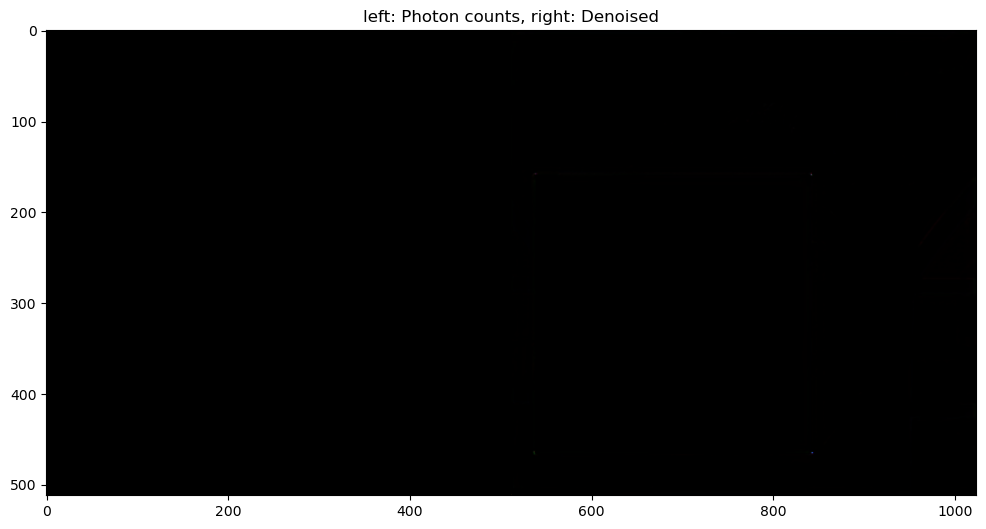

2


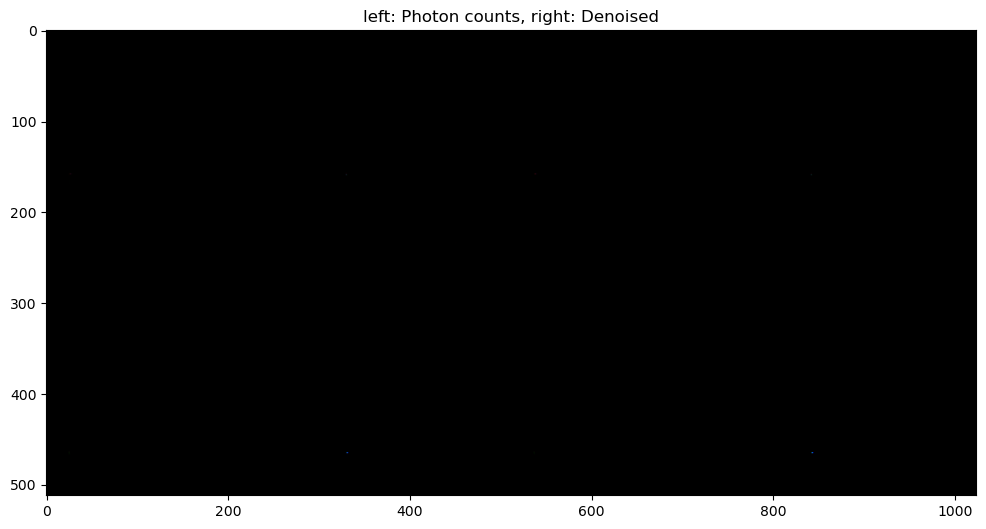

4


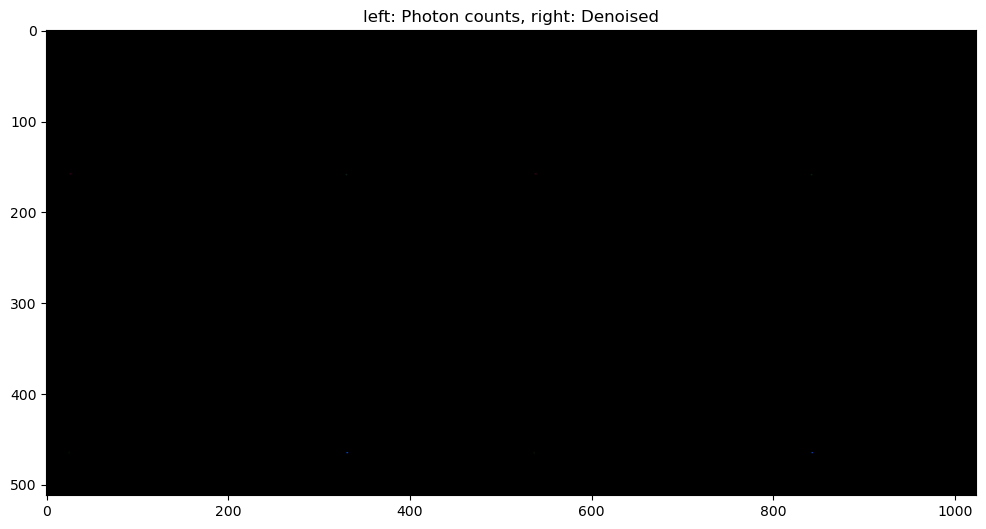

6


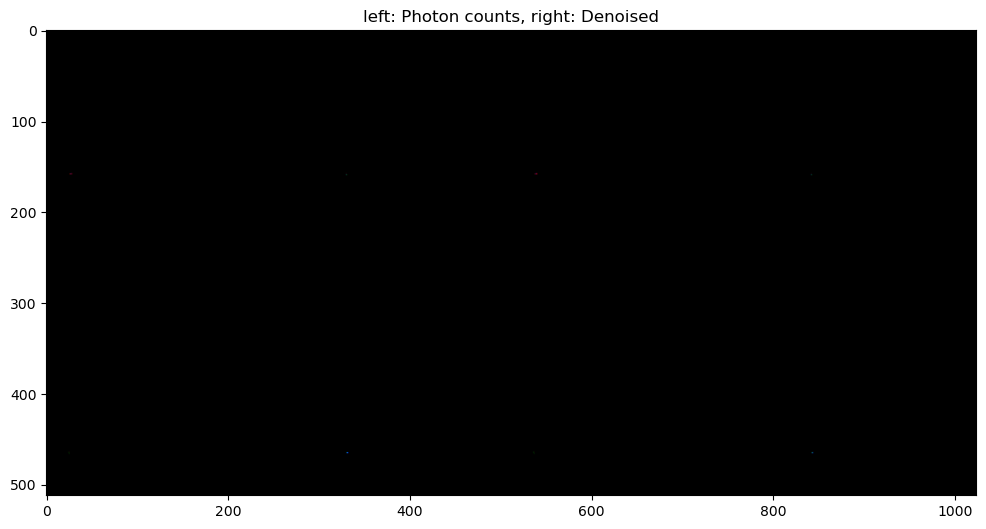

8


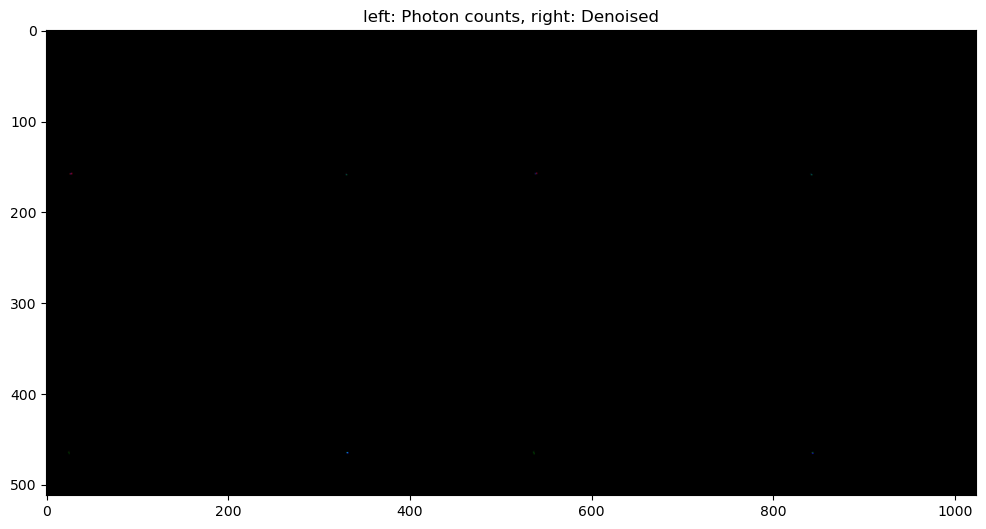

10


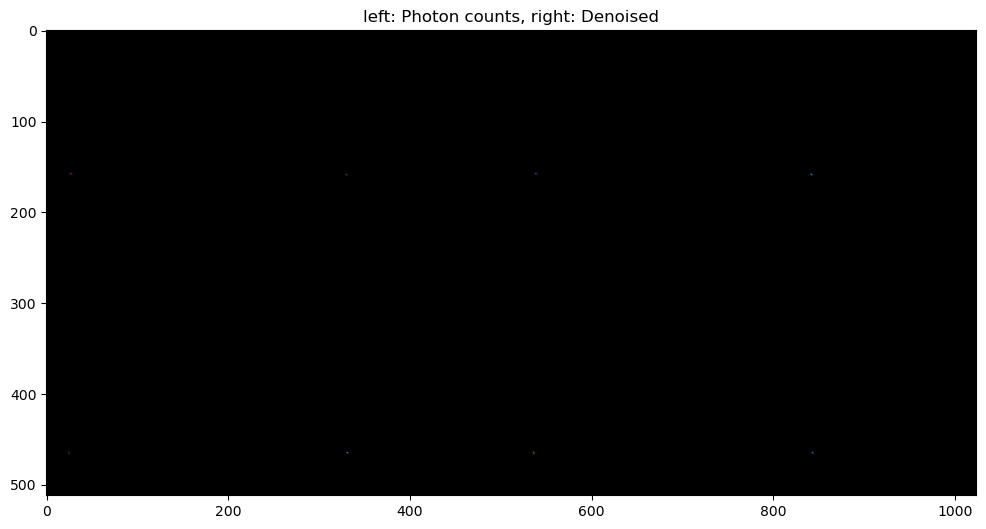

12


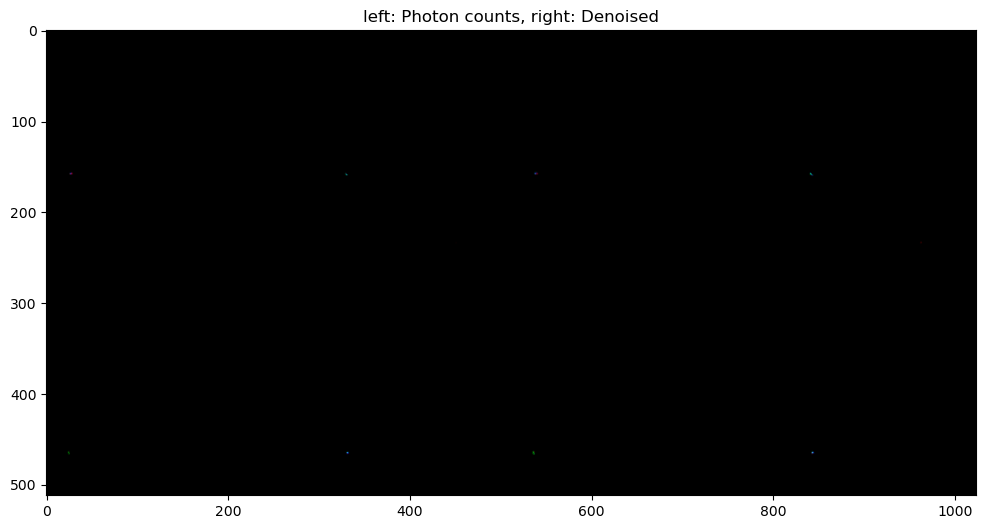

14


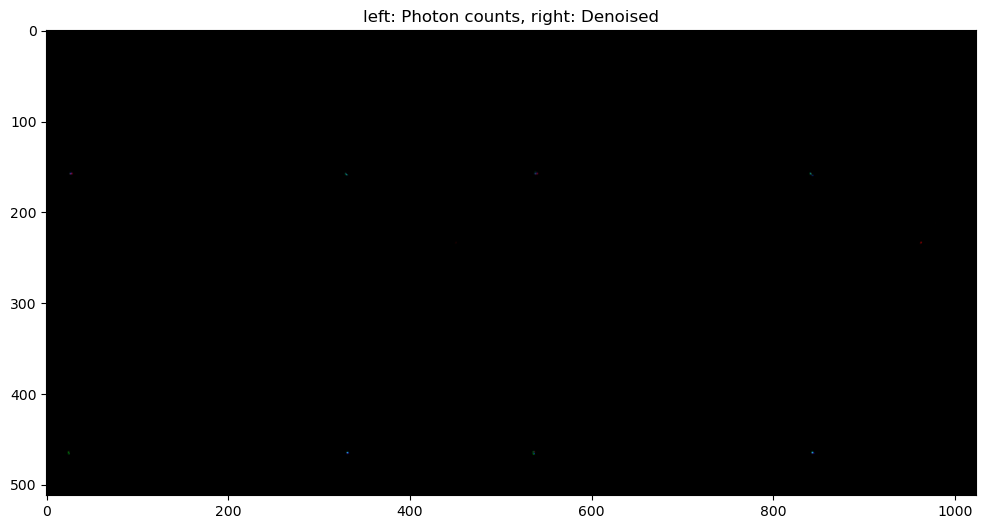

16


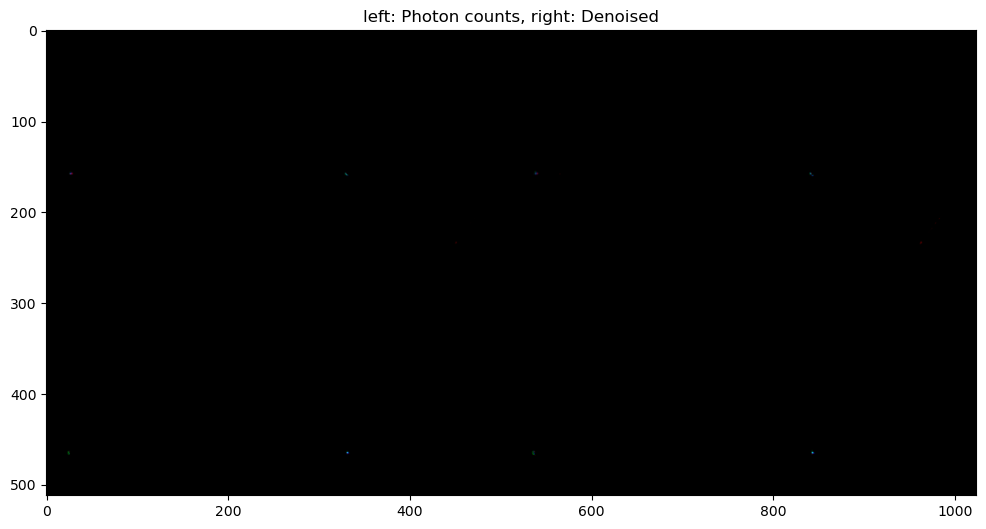

18


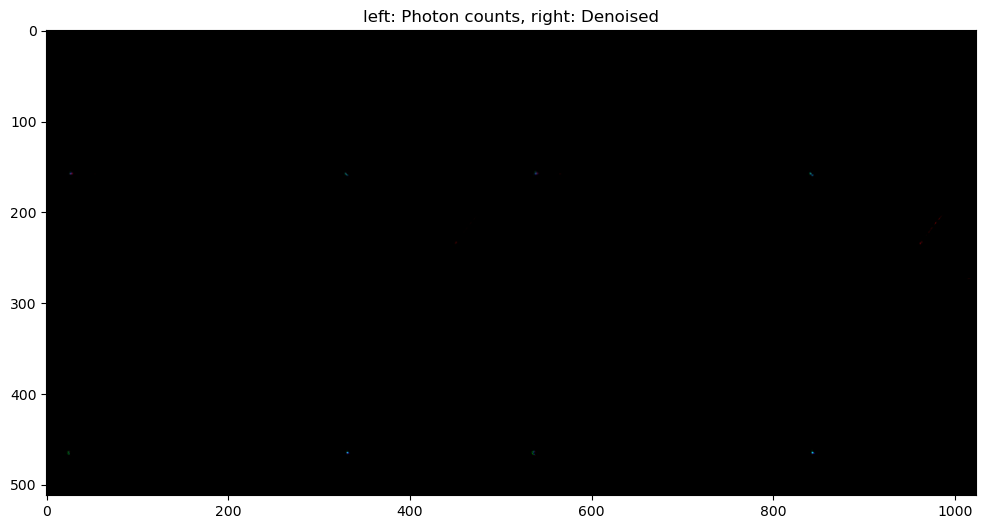

20


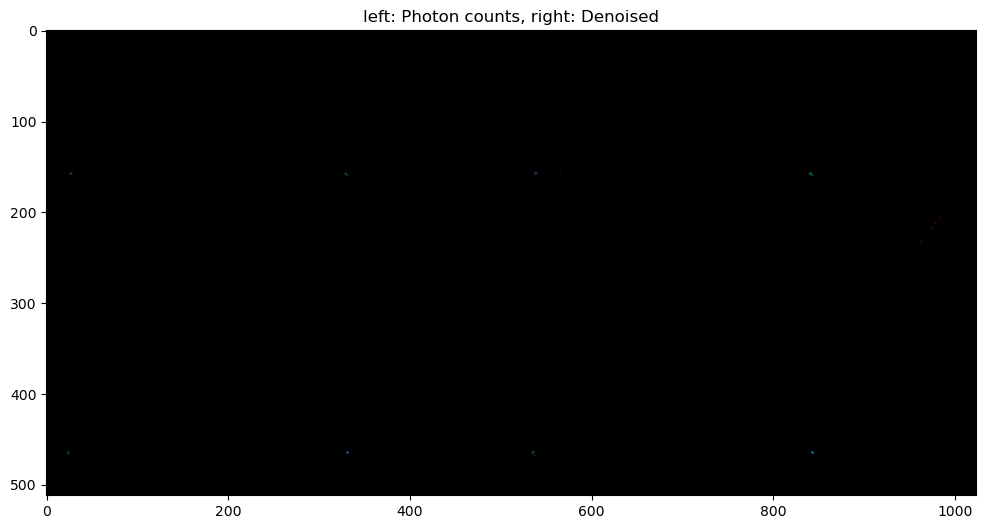

22


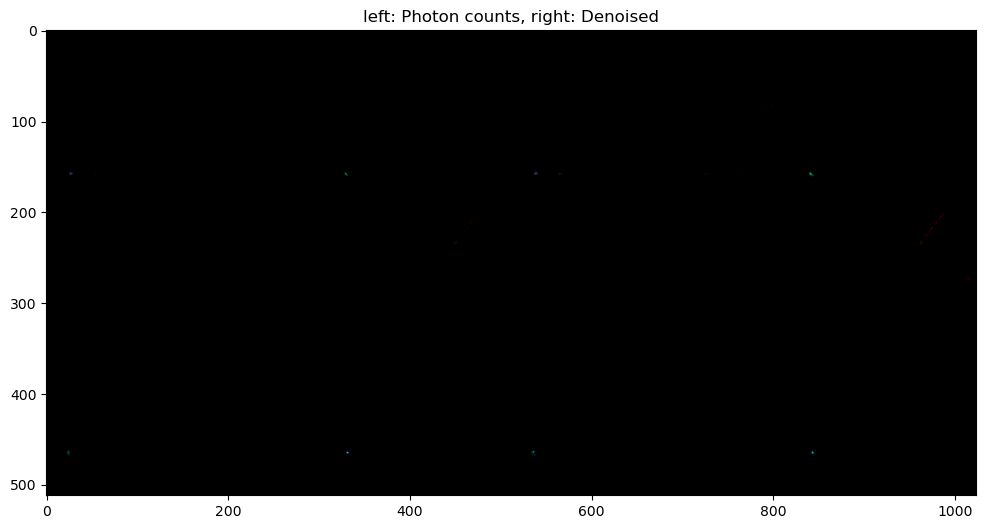

24


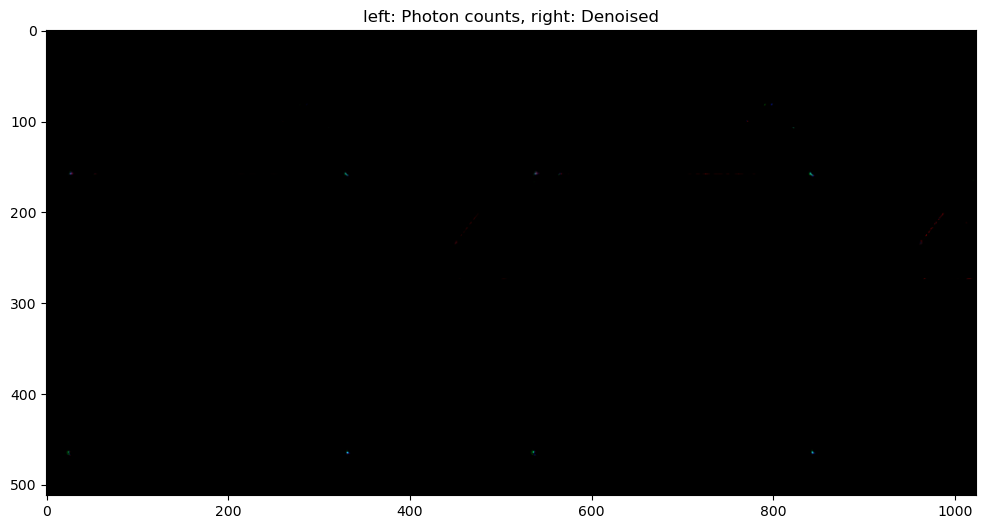

26


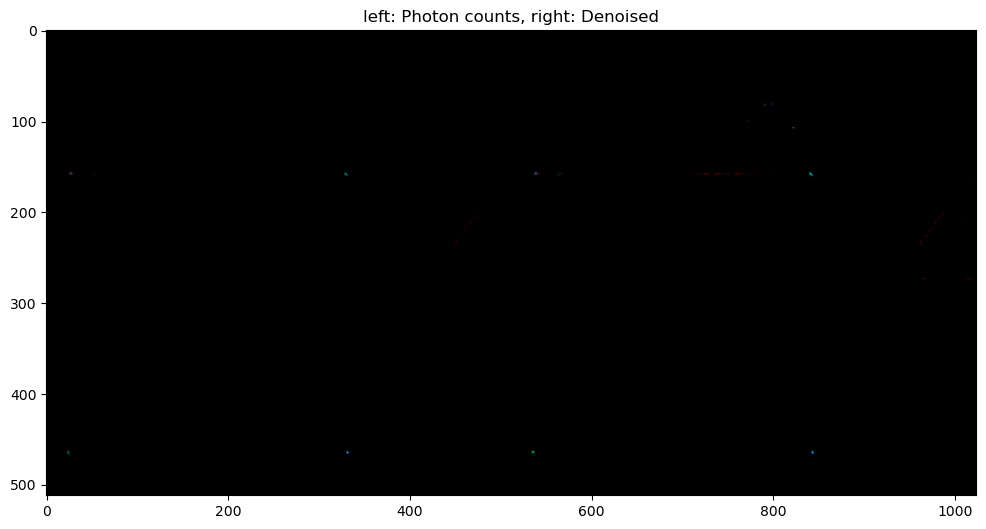

28


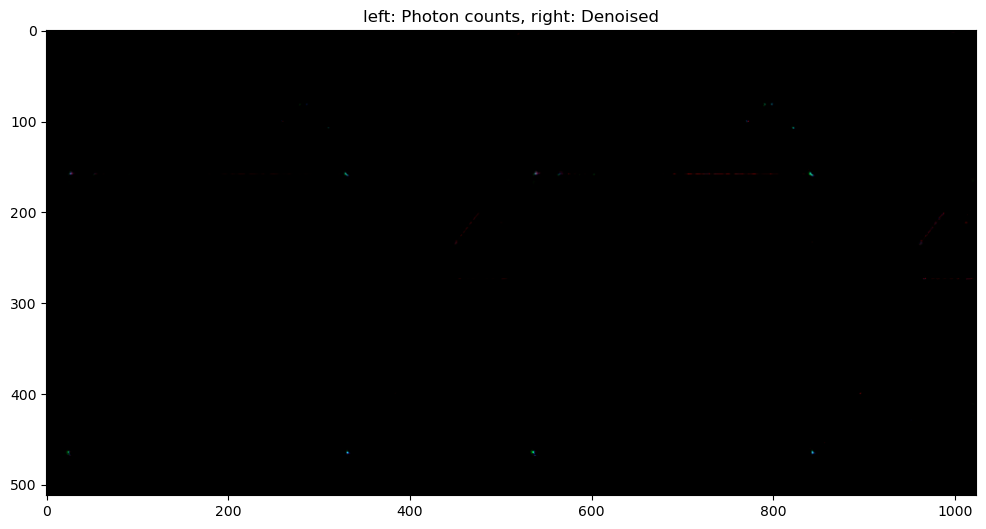

30


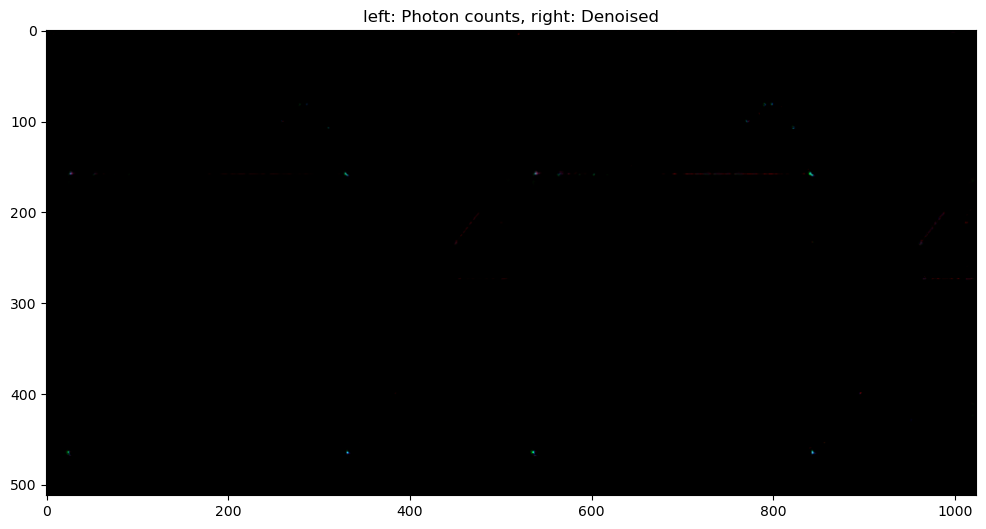

32


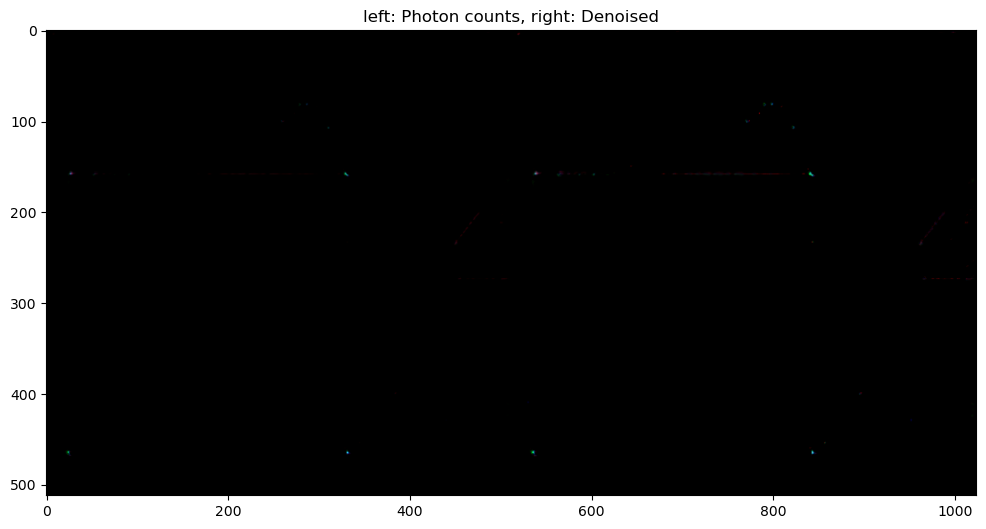

34


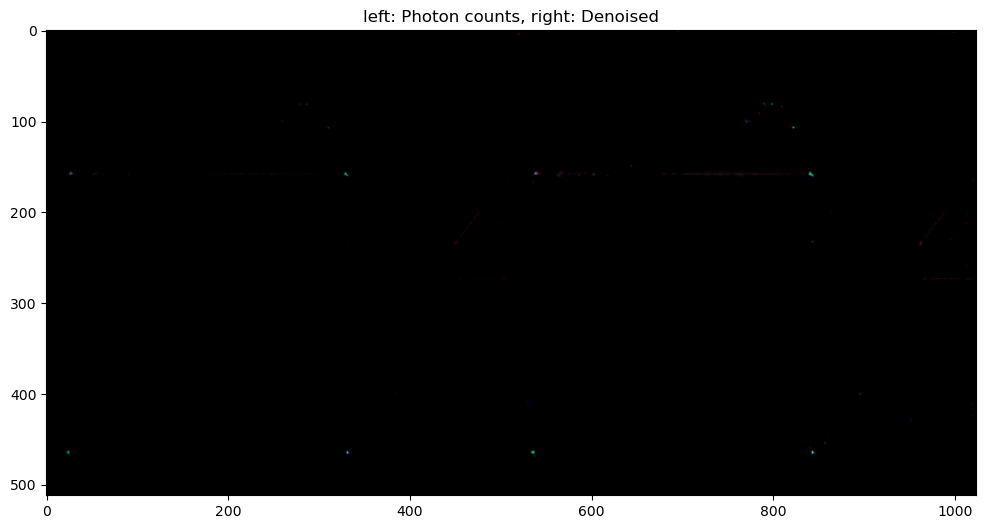

36


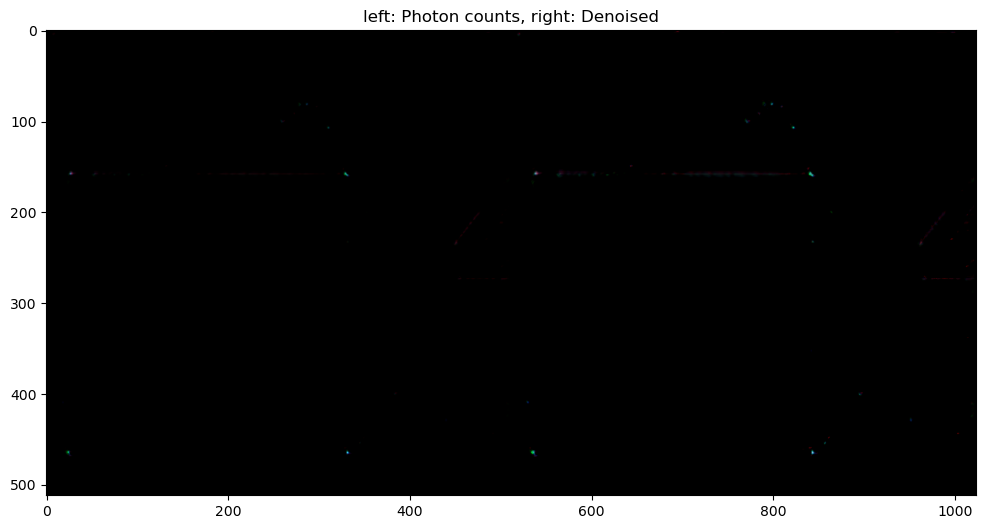

38


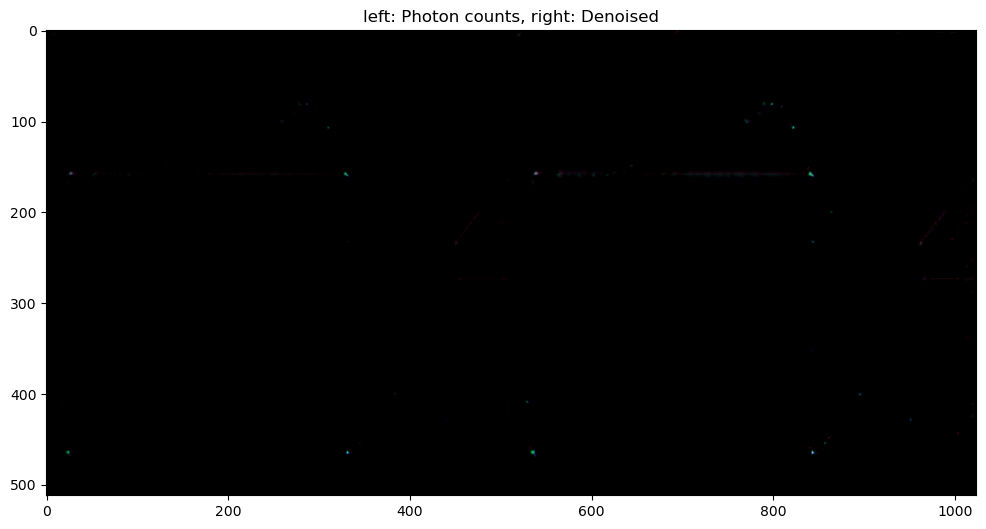

40


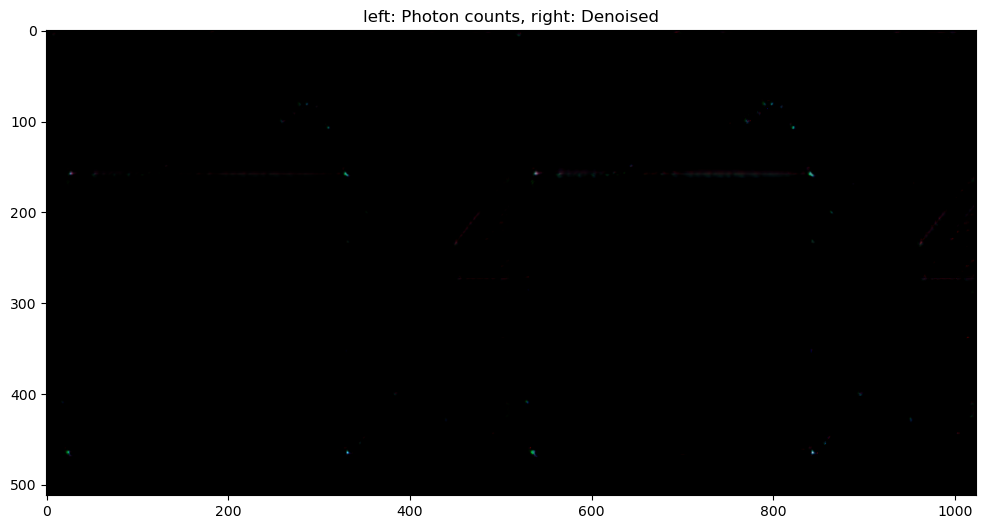

42


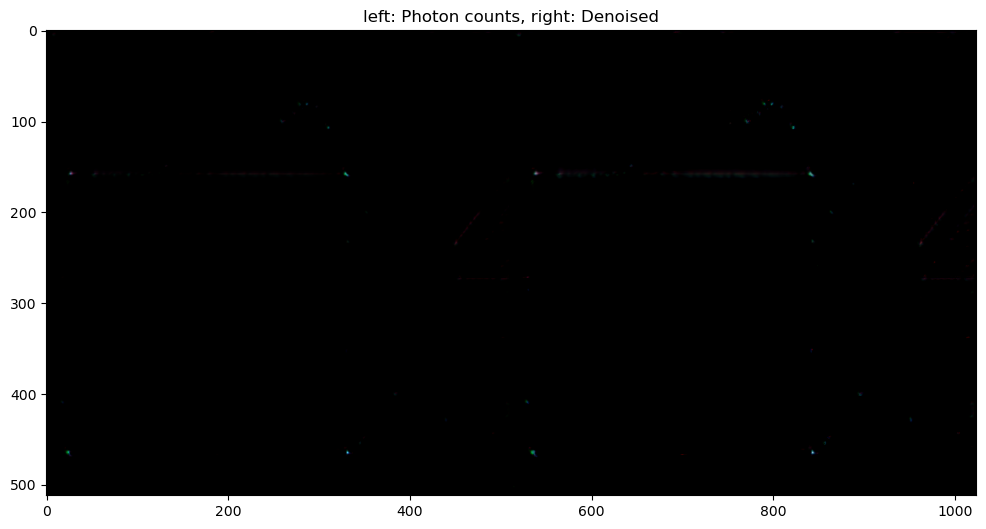

44


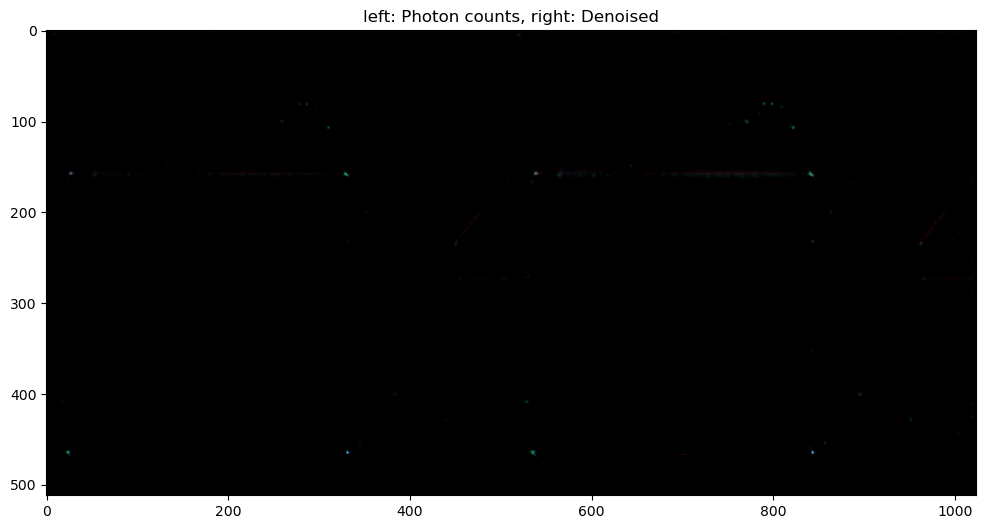

46


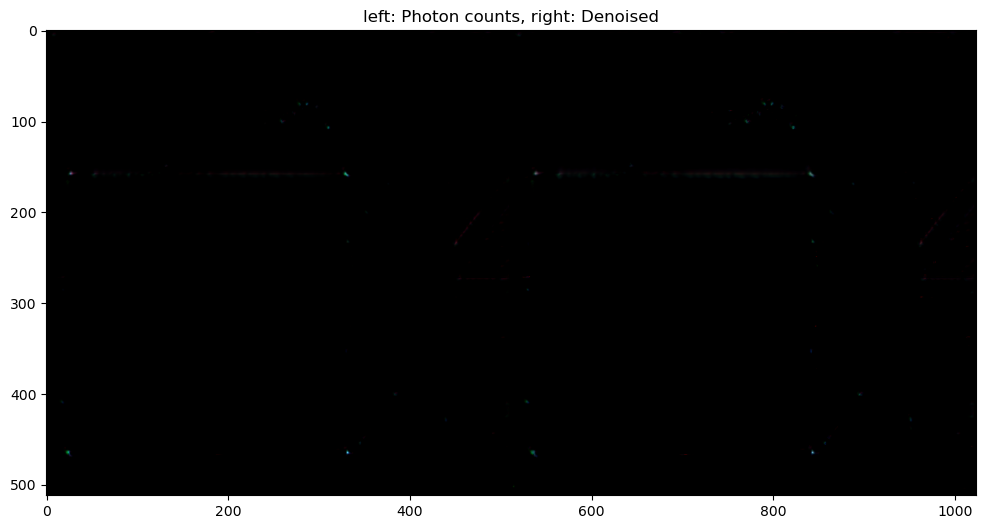

48


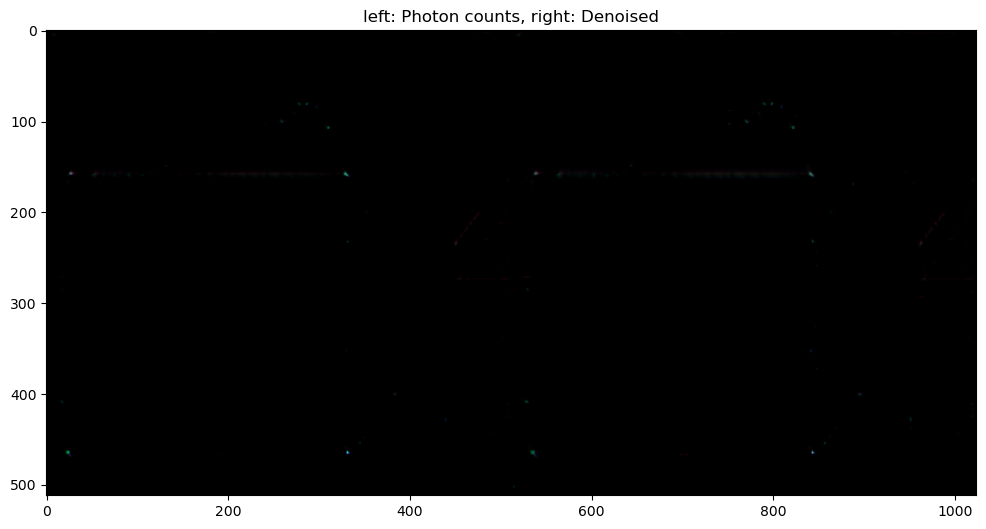

50


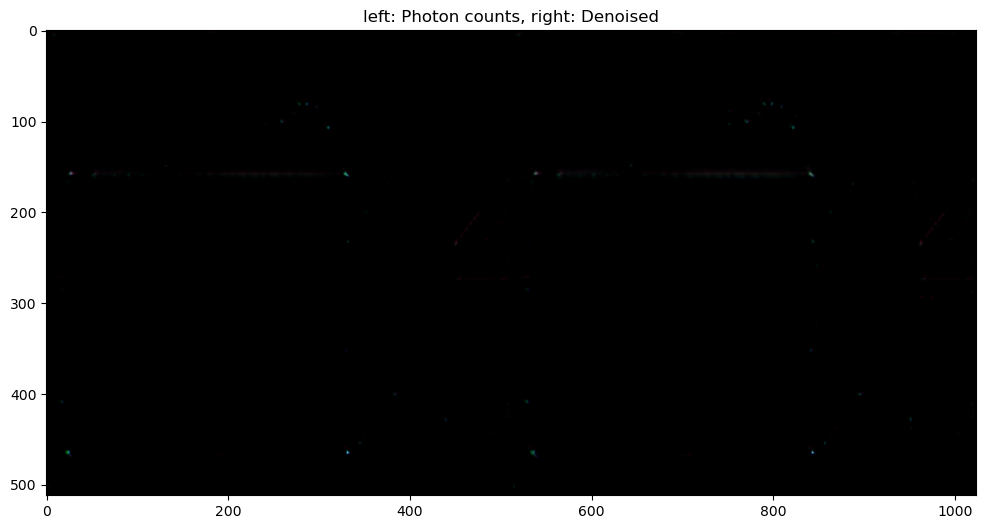

52


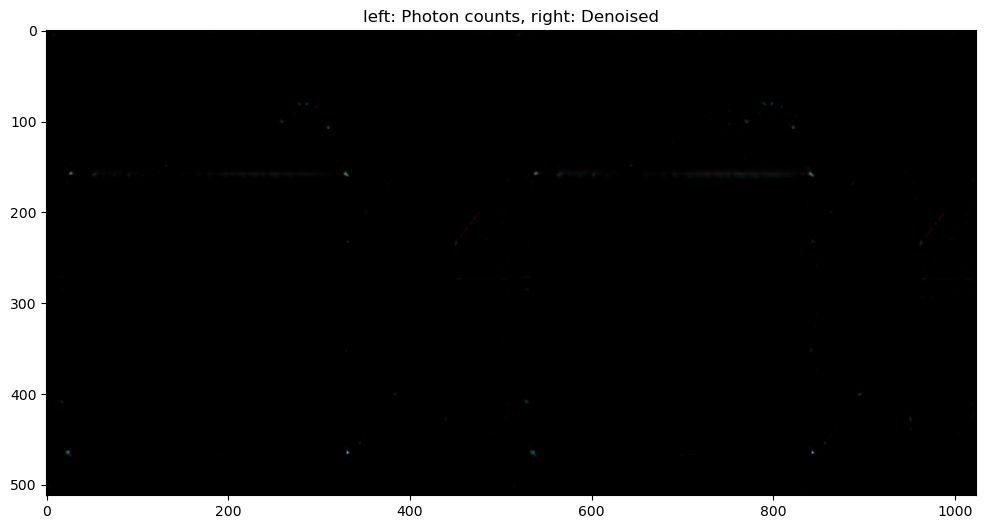

54


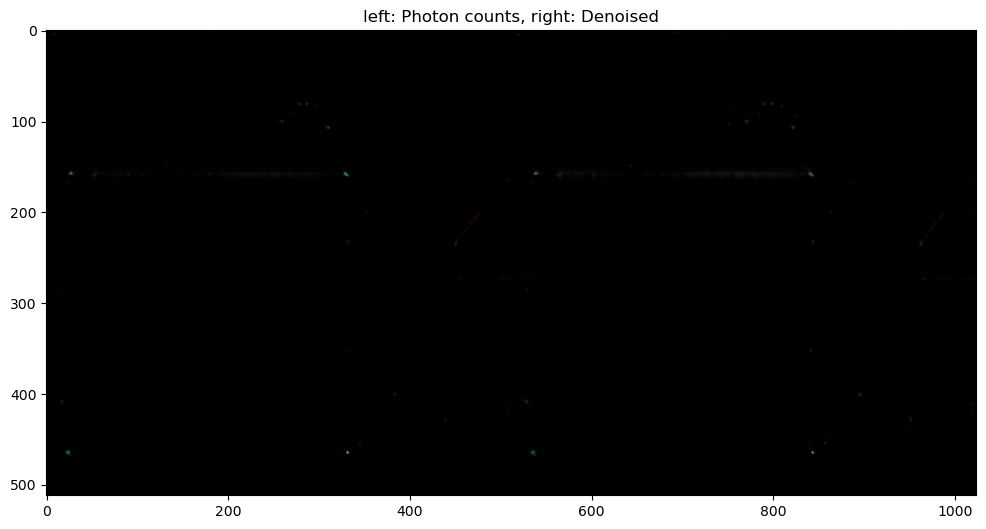

56


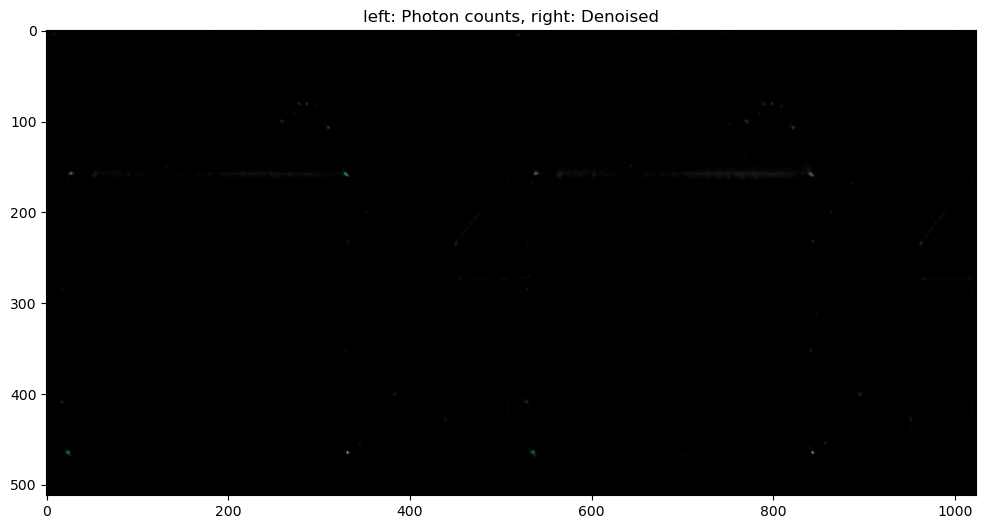

58


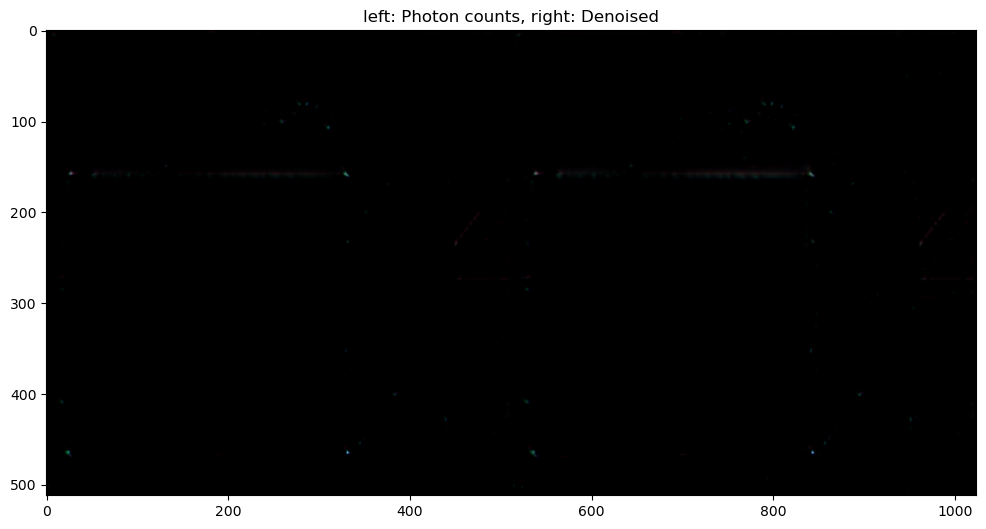

60


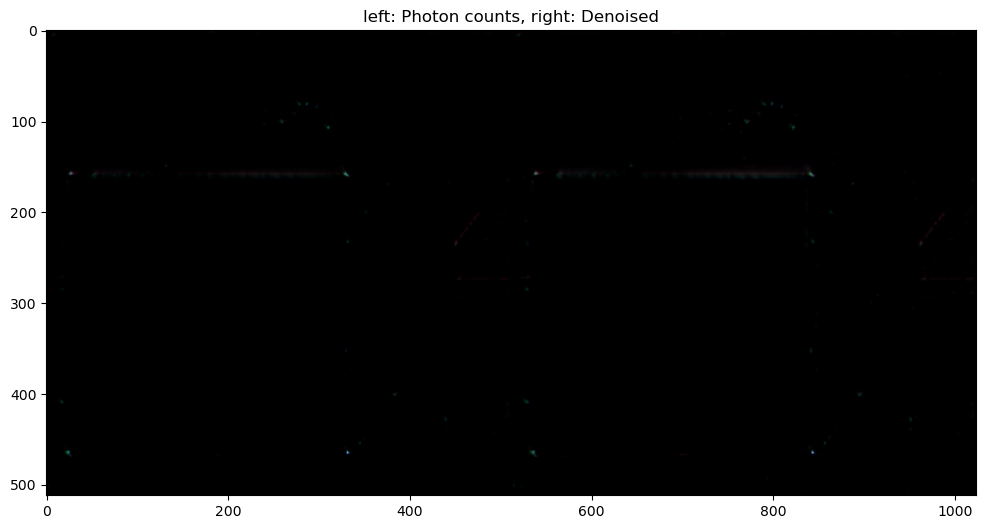

62


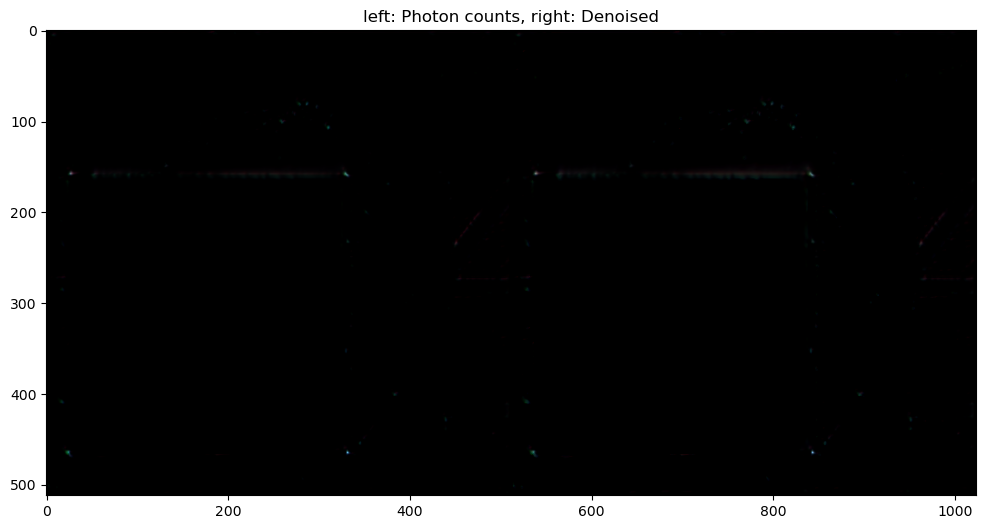

64


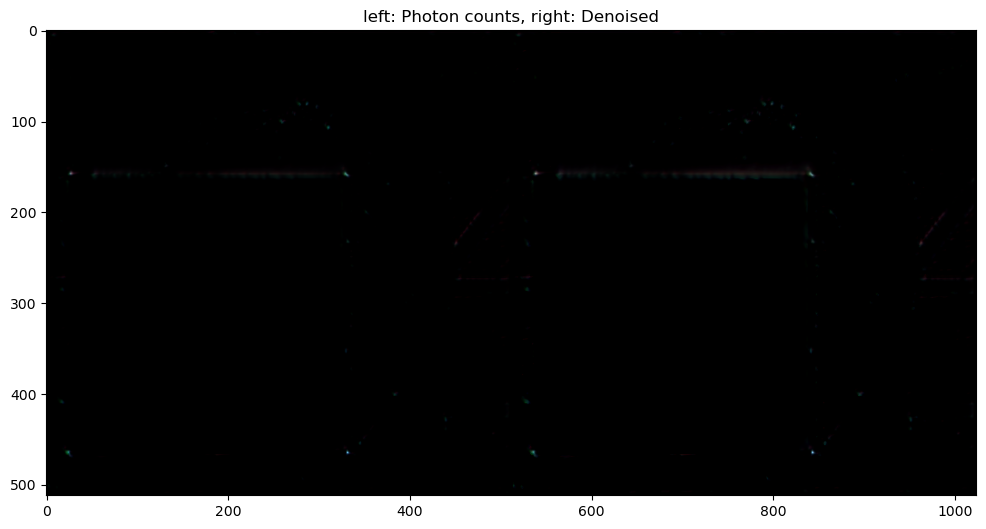

66


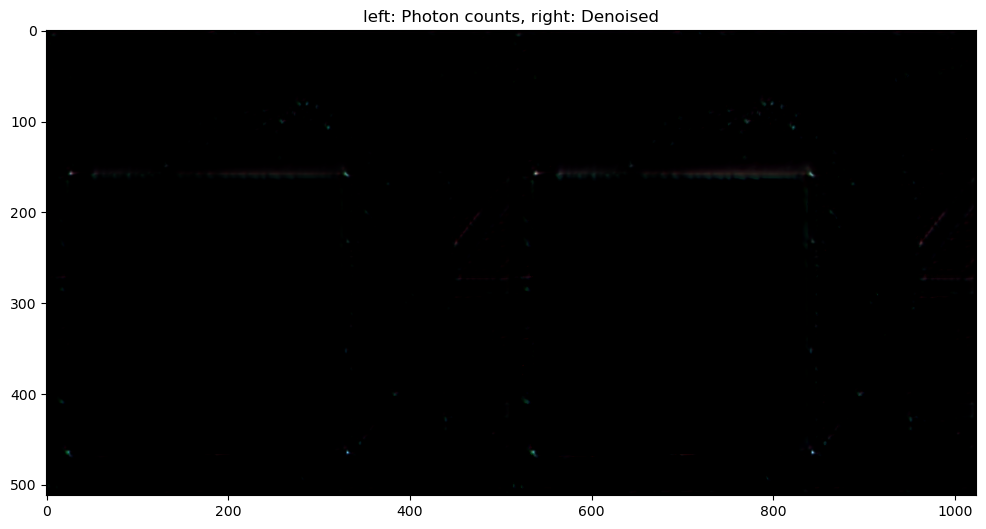

68


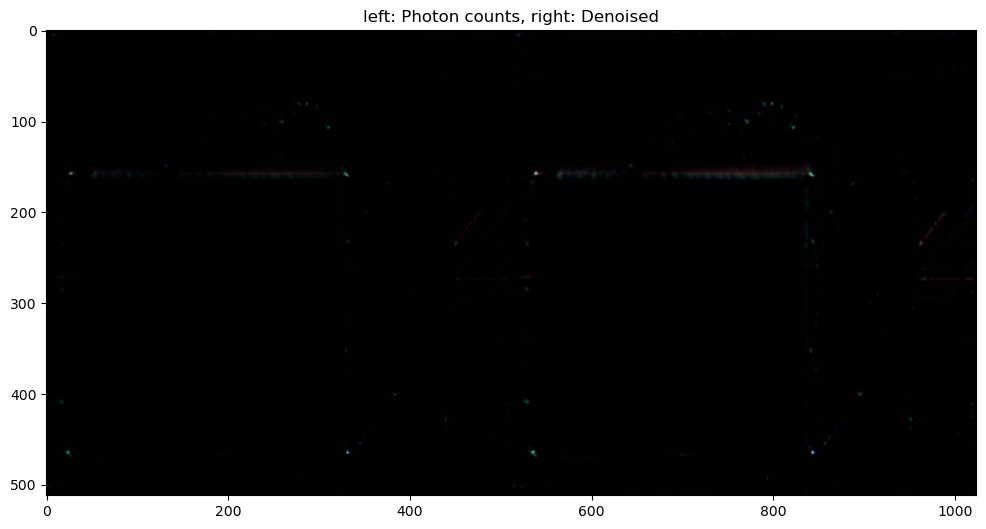

70


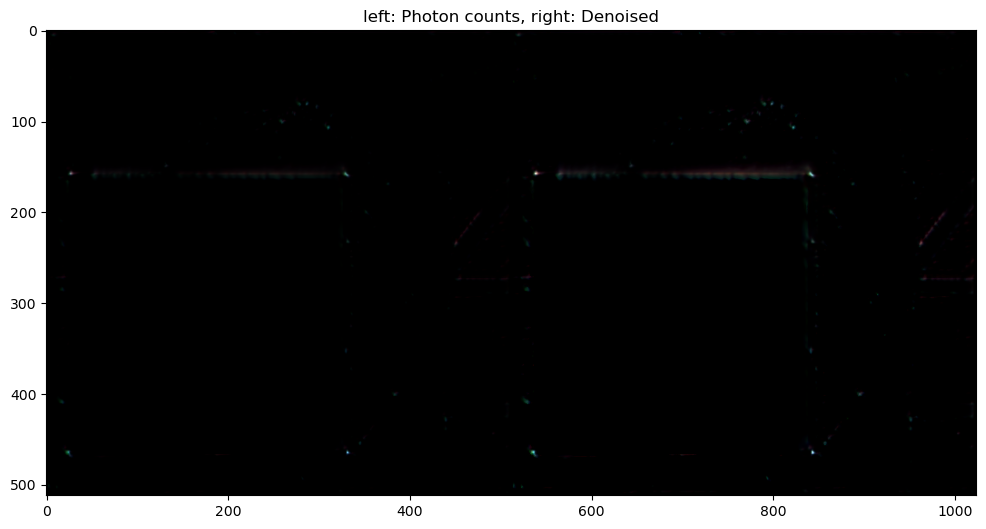

72


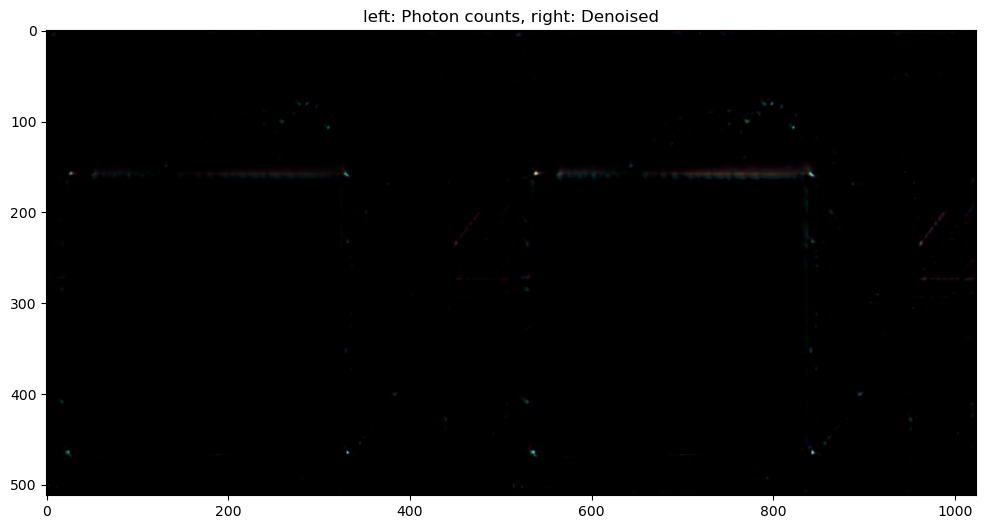

74


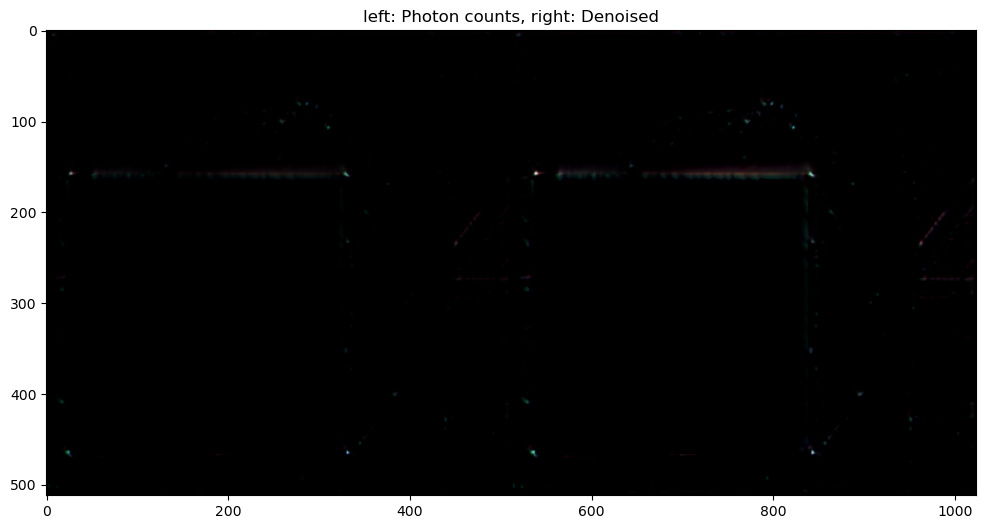

76


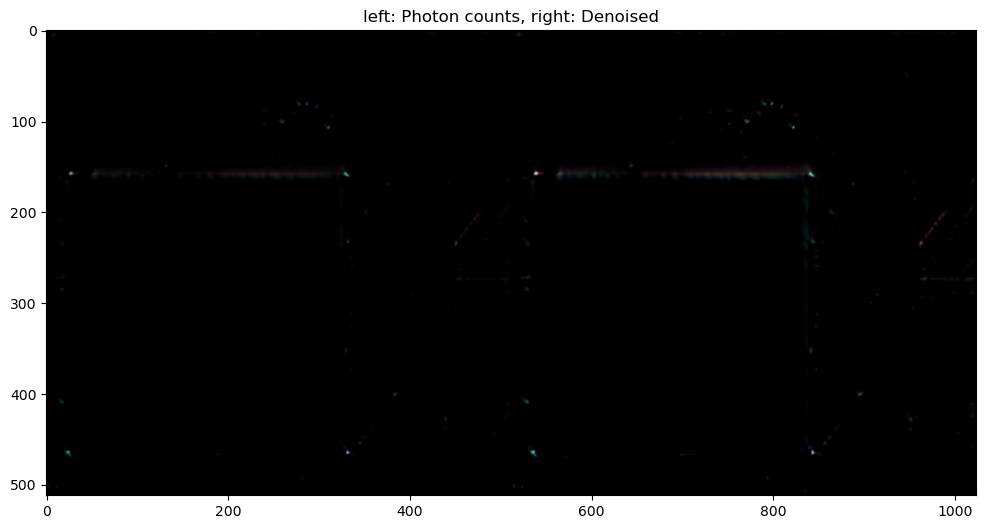

78


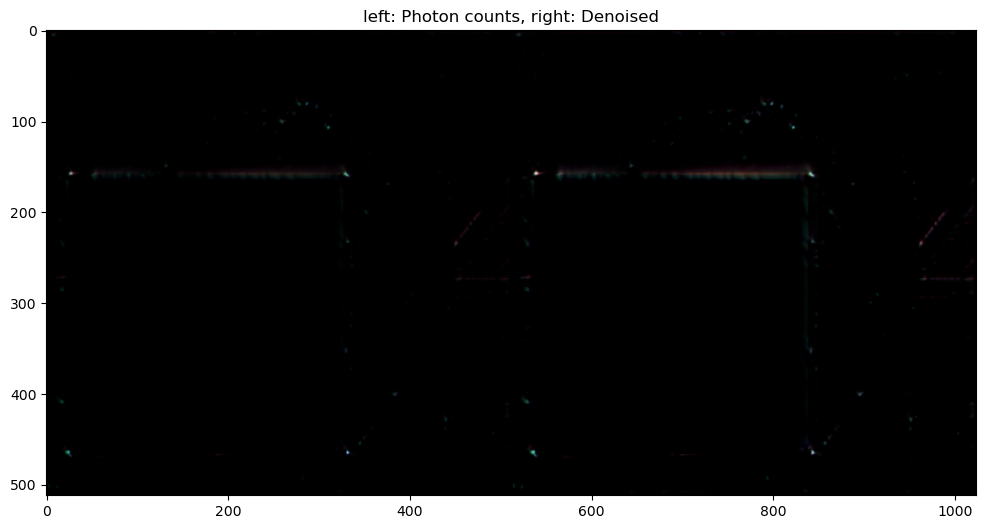

80


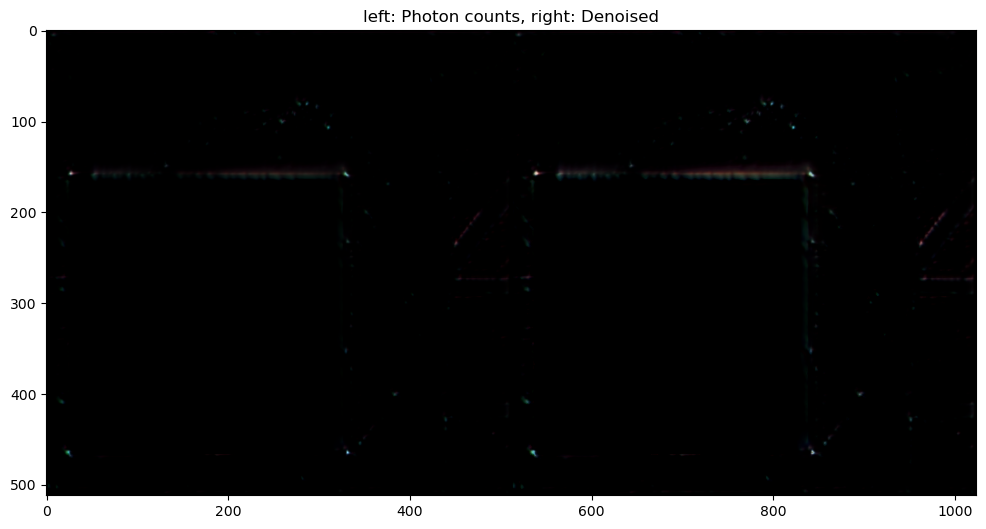

82


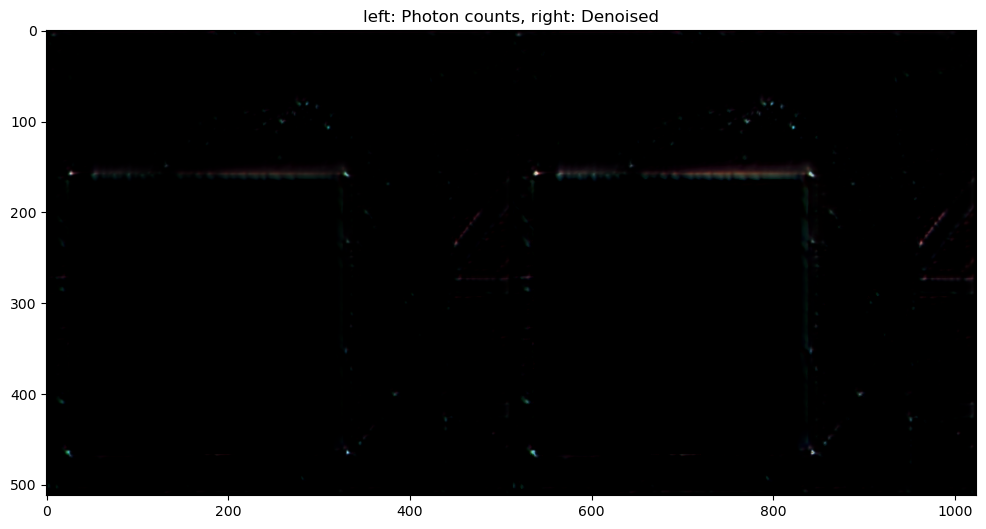

84


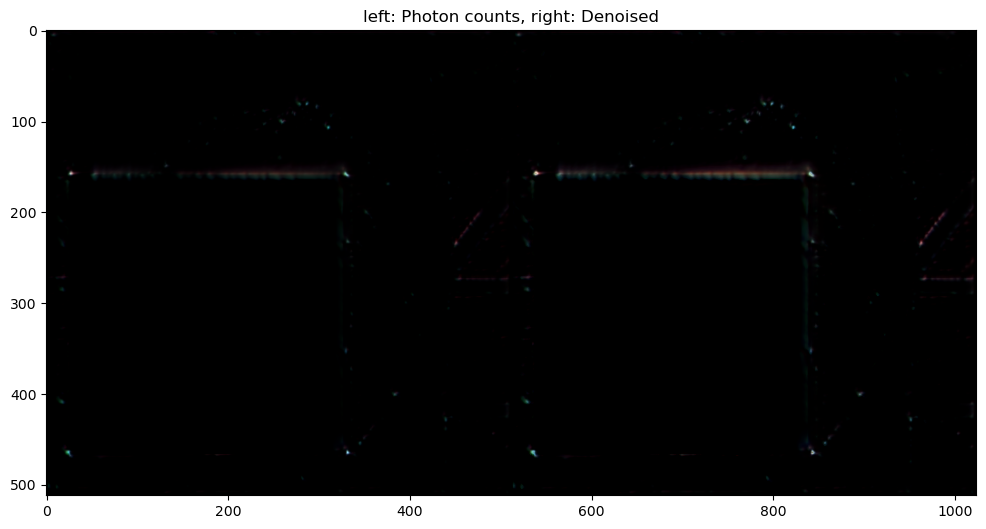

86


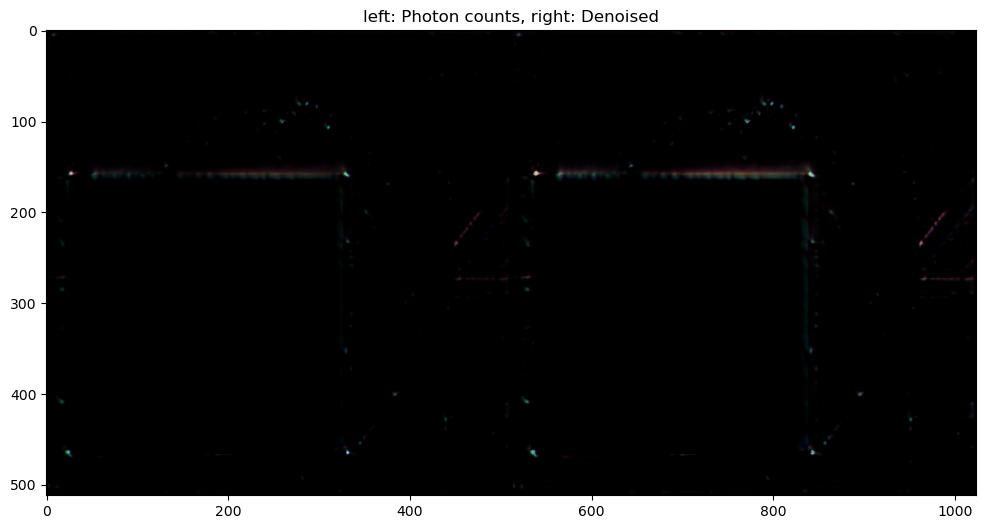

88


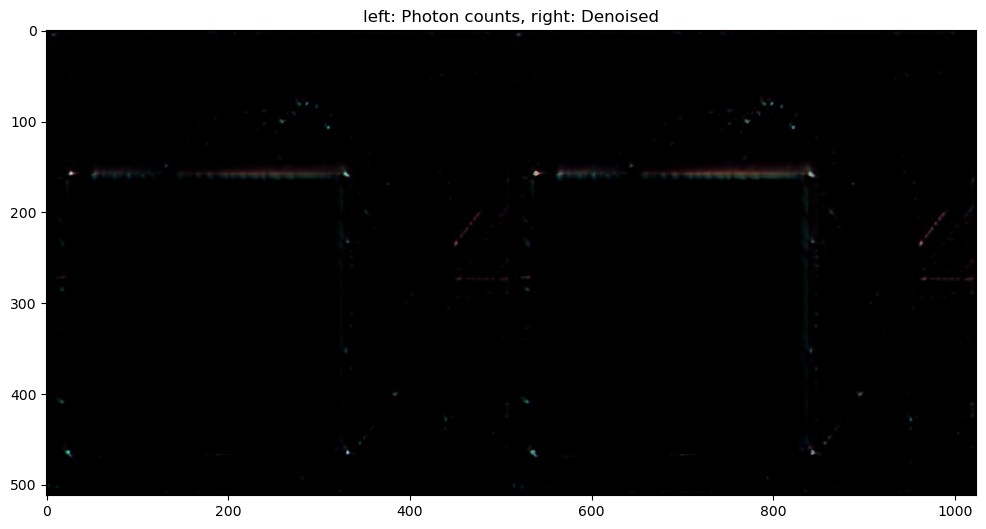

90


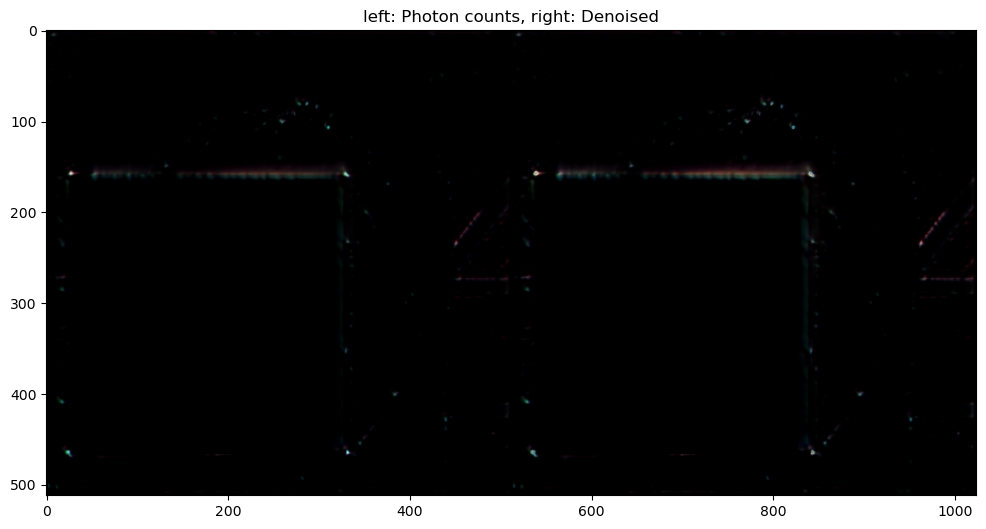

92


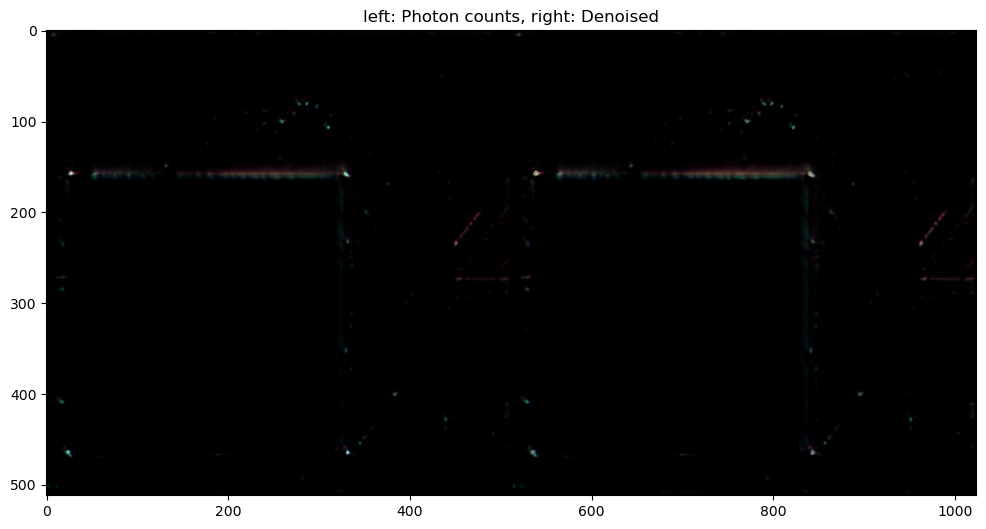

94


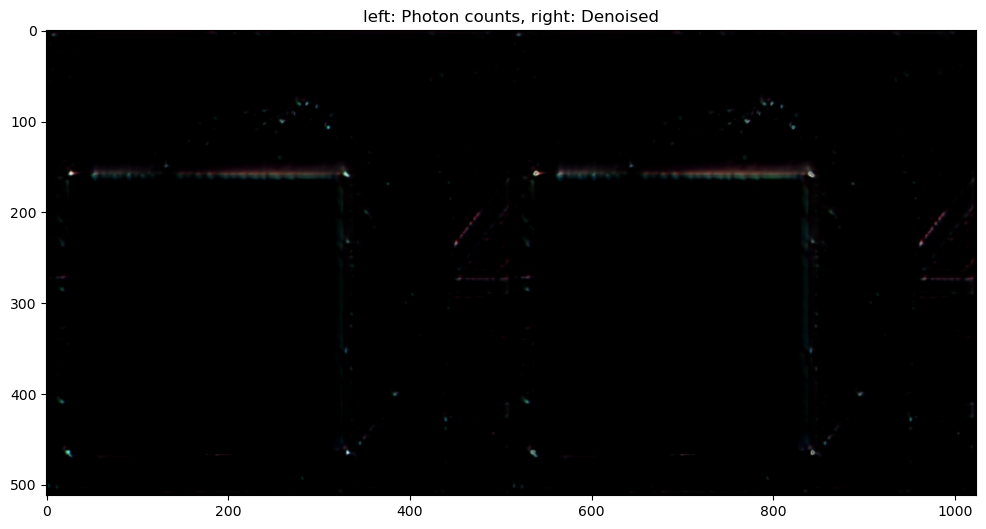

96


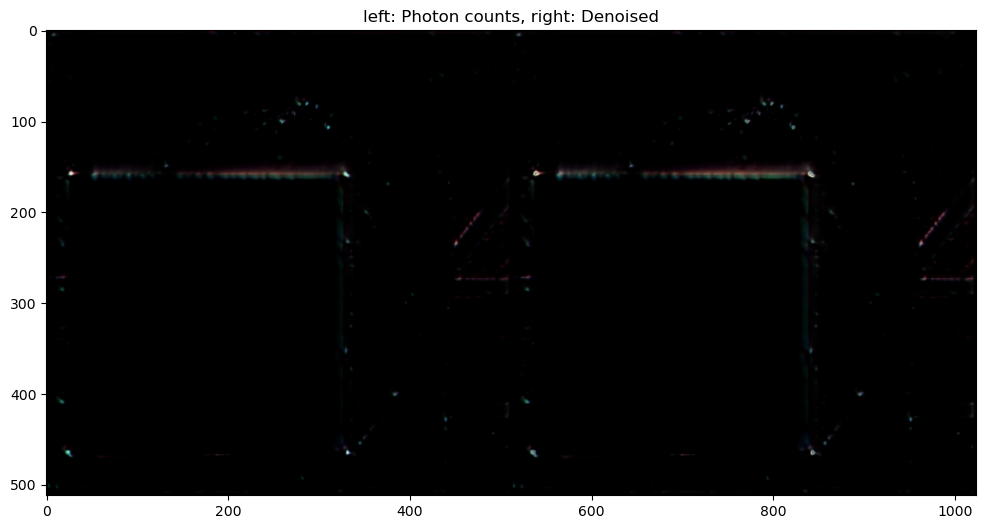

98


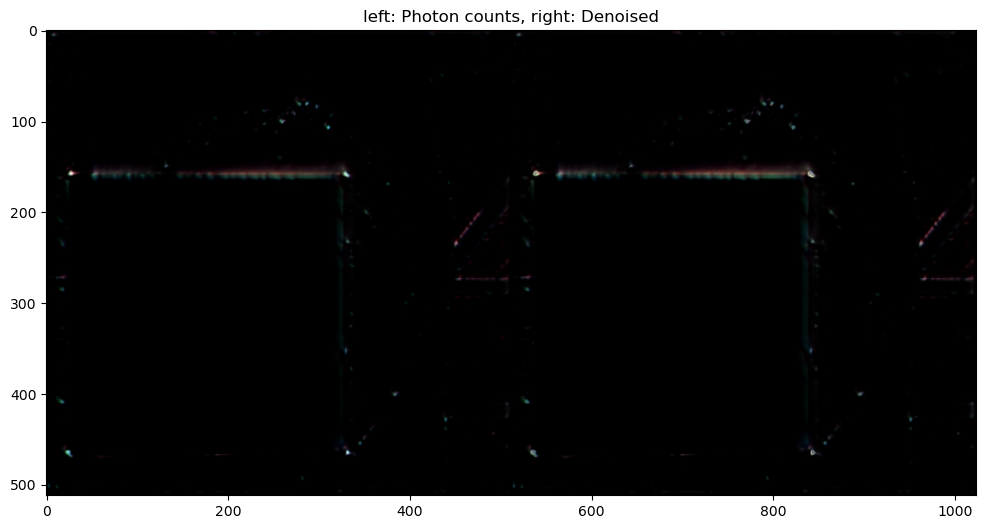

100


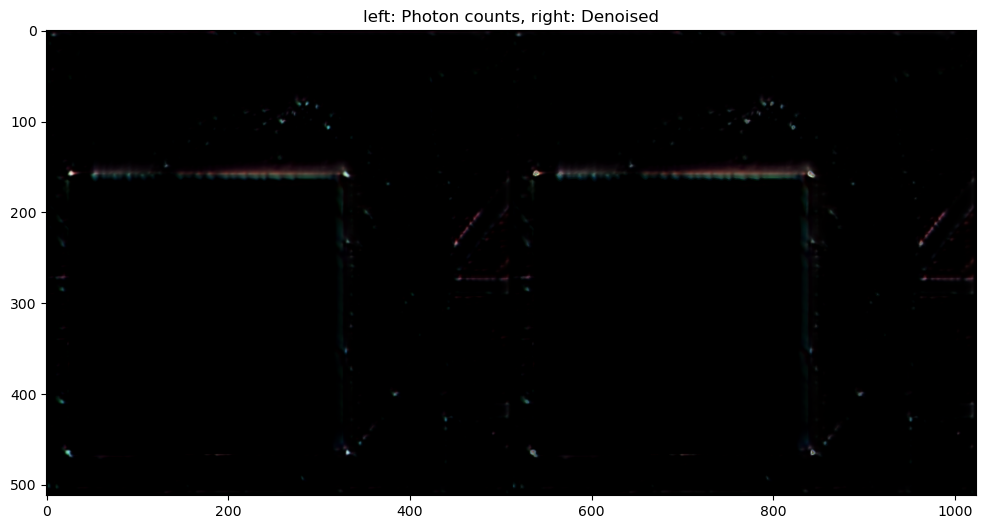

In [85]:
stack[0].shape
for i in range(len(stack)):
    if i%2 == 0 :
        im = (stack[i].transpose(1, 2, 0) * 255).astype(np.uint8)
        print(i)
        plt.figure(figsize = (12,12))
        plt.imshow(im, vmax = 0.9)
        plt.title('left: Photon counts, right: Denoised')
        plt.show()